In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [69]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [83]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps, weight_var=5.0)
std_scaling=1.
mu_scaling=0.2

In [68]:
def nb(mu, std_scaling=std_scaling, mu_scaling=mu_scaling):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    try:
        nb_mu = nbinom.rvs(n, p)
    except:
        print(n)
        print(p)
        import pdb; pdb.set_trace()
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Run Task (with learning)

In [94]:
def run():
    # Set up
    cache_states = np.random.choice(99, 5, replace=False)
    model.reset()
    cache_acts = []

    # Run learning
    for cache_state in cache_states:
        print("Now I just cached at location:", cache_state)
        preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
        model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
        cache_acts.append(acts_over_time[-1, cache_state].copy())

    # Get retrieval activation
    _, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)
    retrieval_acts = retrieval_acts_over_time[-1]

    # Place activity
    _, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
    place_mean = np.mean(place_acts, axis=0).flatten()
    place_std = np.std(place_acts, axis=0).flatten()

    # Cache activity
    cache_acts = np.array(cache_acts)
    
    # If anything with NaNs, skip
    if np.any(np.isnan(cache_acts)):
        return None, None
    if np.any(np.isnan(retrieval_acts)):
        return None, None
    if np.any(np.isnan(place_acts)):
        return None, None

    # Collect data
    cache_cache_corr = {'Distance': [], 'Correlation': []}
    cache_visit_corr = {'Distance': [], 'Correlation': []}
    visit_visit_corr = {'Distance': [], 'Correlation': []}
    cache_retrieval_corr = {'Distance': [], 'Correlation': []}

    for i in range(len(cache_states)):
        for j in range(i, len(cache_states)):
            _distance = distance(cache_states[i], cache_states[j], num_states)

            cache_act_i = cache_acts[i].copy()
            cache_act_j = cache_acts[j].copy()
            retrieval_act_j = retrieval_acts[cache_states[j]].copy()
            place_act_i = place_acts[cache_states[i]].copy()
            place_act_j = place_acts[cache_states[j]].copy()

            for _ in range(3): # More samples
                c_c_corr = nb_corr(cache_act_i, cache_act_j)
                c_v_corr = nb_corr(cache_act_i, place_act_j)
                v_v_corr = nb_corr(place_act_i, place_act_j)
                c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

                cache_cache_corr['Distance'].append(_distance)
                cache_cache_corr['Correlation'].append(c_c_corr)

                cache_visit_corr['Distance'].append(_distance)
                cache_visit_corr['Correlation'].append(c_v_corr)

                visit_visit_corr['Distance'].append(_distance)
                visit_visit_corr['Correlation'].append(v_v_corr)

                cache_retrieval_corr['Distance'].append(_distance)
                cache_retrieval_corr['Correlation'].append(c_r_corr)

    visit_visit_df = pd.DataFrame(visit_visit_corr)
    cache_retrieve_df = pd.DataFrame(cache_retrieval_corr)
    norm_constant = np.mean(
       visit_visit_df[visit_visit_df['Distance']==0]['Correlation'])
    visit_visit_df['Correlation'] = visit_visit_df['Correlation'].div(norm_constant)
    cache_retrieve_df['Correlation'] = cache_retrieve_df['Correlation'].div(norm_constant)
    
    return visit_visit_df, cache_retrieve_df

# Collect

In [95]:
iters = 20
n_samples = 0
visit_visit_df = []
cache_retrieve_df = []
while n_samples < iters:
    v, c = run()
    if v is None:
        print('Error. Re-running.')
        continue
    print(f'Iteration {_iter} completed.')
    visit_visit_df.append(v)
    cache_retrieve_df.append(c)
    n_samples += 1

Now I just cached at location: 14
Now I just cached at location: 78
Now I just cached at location: 96
Now I just cached at location: 80
Now I just cached at location: 71


/share/ctn/users/cf2794/Code/barcodes/Model.py:106: RuntimeWarning: invalid value encountered in matmul
  preacts = preacts*(1 - divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar * dt) + dt*np.matmul(acts, J_xx)+dt*(inputs+self.J_sx*seed_strength_cache)
/share/ctn/users/cf2794/Code/barcodes/Model.py:106: RuntimeWarning: overflow encountered in multiply
  preacts = preacts*(1 - divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar * dt) + dt*np.matmul(acts, J_xx)+dt*(inputs+self.J_sx*seed_strength_cache)


Error. Re-running.
Now I just cached at location: 42
Now I just cached at location: 13
Now I just cached at location: 59
Now I just cached at location: 5
Now I just cached at location: 84
Iteration 0 completed.
Now I just cached at location: 8
Now I just cached at location: 31
Now I just cached at location: 29
Now I just cached at location: 54
Now I just cached at location: 85
Error. Re-running.
Now I just cached at location: 0
Now I just cached at location: 91
Now I just cached at location: 30
Now I just cached at location: 62
Now I just cached at location: 53
Iteration 0 completed.
Now I just cached at location: 71
Now I just cached at location: 95
Now I just cached at location: 12
Now I just cached at location: 93
Now I just cached at location: 19
Error. Re-running.
Now I just cached at location: 73
Now I just cached at location: 61
Now I just cached at location: 26
Now I just cached at location: 92
Now I just cached at location: 31
Iteration 0 completed.
Now I just cached at locati

/share/ctn/users/cf2794/Code/barcodes/Model.py:101: RuntimeWarning: overflow encountered in matmul
  preacts = preacts*(1 - divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar * dt) + dt*np.matmul(acts, J_xx)+dt*inputs
/share/ctn/users/cf2794/Code/barcodes/Model.py:101: RuntimeWarning: invalid value encountered in add
  preacts = preacts*(1 - divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar * dt) + dt*np.matmul(acts, J_xx)+dt*inputs


Now I just cached at location: 82
Error. Re-running.
Now I just cached at location: 9
Now I just cached at location: 45
Now I just cached at location: 33
Now I just cached at location: 97
Now I just cached at location: 57
Iteration 0 completed.
Now I just cached at location: 94
Now I just cached at location: 28
Now I just cached at location: 91
Now I just cached at location: 5
Now I just cached at location: 88
Error. Re-running.
Now I just cached at location: 11
Now I just cached at location: 31
Now I just cached at location: 92
Now I just cached at location: 25
Now I just cached at location: 18
Iteration 0 completed.
Now I just cached at location: 75
Now I just cached at location: 44
Now I just cached at location: 61
Now I just cached at location: 58
Now I just cached at location: 60


/share/ctn/users/cf2794/Code/barcodes/Model.py:116: RuntimeWarning: invalid value encountered in matmul
  final_output = np.matmul(final_acts, self.J_xy.transpose())


Error. Re-running.
Now I just cached at location: 2
Now I just cached at location: 25
Now I just cached at location: 37
Now I just cached at location: 60
Now I just cached at location: 71
Iteration 0 completed.
Now I just cached at location: 53
Now I just cached at location: 66
Now I just cached at location: 58
Now I just cached at location: 35
Now I just cached at location: 59
Error. Re-running.
Now I just cached at location: 22
Now I just cached at location: 66
Now I just cached at location: 68
Now I just cached at location: 80
Now I just cached at location: 87
Error. Re-running.
Now I just cached at location: 78
Now I just cached at location: 74
Now I just cached at location: 28
Now I just cached at location: 9
Now I just cached at location: 86
Error. Re-running.
Now I just cached at location: 40
Now I just cached at location: 95
Now I just cached at location: 1
Now I just cached at location: 28
Now I just cached at location: 4
Error. Re-running.
Now I just cached at location: 7
Now

Now I just cached at location: 8
Now I just cached at location: 43
Now I just cached at location: 5
Now I just cached at location: 71
Error. Re-running.
Now I just cached at location: 64
Now I just cached at location: 23
Now I just cached at location: 42
Now I just cached at location: 81
Now I just cached at location: 32
Iteration 0 completed.
Now I just cached at location: 49
Now I just cached at location: 6
Now I just cached at location: 34
Now I just cached at location: 40
Now I just cached at location: 98
Iteration 0 completed.
Now I just cached at location: 58
Now I just cached at location: 33
Now I just cached at location: 97
Now I just cached at location: 5
Now I just cached at location: 38
Iteration 0 completed.


In [96]:
visit_visit_df = pd.concat(visit_visit_df)
cache_retrieve_df = pd.concat(cache_retrieve_df)

# Plot

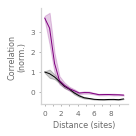

In [110]:
fig, ax = plt.subplots(figsize=(2.,2.))
for df, color in zip(
    [visit_visit_df, cache_retrieve_df], ['black', 'purple']):

    # Plot curve as a line
    x_values = np.linspace(0, max(df['Distance']), 100)
    bins = np.arange(0, 55, 3)
    df['Binned Distance'] = pd.cut(
        df['Distance'], bins=bins, right=False, labels=[i for i in bins[:-1]])
    sns.lineplot(x='Binned Distance', y='Correlation', data=df, color=color)
    
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
           [0, '', 2, '', 4, '', 6, '', 8, ''])
plt.xlabel('Distance (sites)')
plt.ylabel('Correlation\n(norm.)')
plt.tight_layout()
plt.yticks([0, 1, 2, 3])
plt.savefig('c_r_corr.png', dpi=300)
plt.show()